# 05. Integration of CITE-seq data

CITE-seq is a multiomics technology which provides RNA-seq and surface protein expression from the same cells. In this tutorial, we introduce how to integrate the two modalities of CITE-seq data using scMaui. We use a subset of CITE-seq data downloaded from [GSE194122](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122).

### Load data
We have 5,584 cells with 13,953 RNA-seq features and 134 proteins. 

In [1]:
from anndata import read_h5ad
import warnings
warnings.filterwarnings('ignore') # to remove warnings
f_data="../data/CITE-seq/citeseq_sample.h5ad"
ad_data = read_h5ad(f_data)
ad_data.X = ad_data.layers["counts"] # We start with raw counts
ad_data

AnnData object with n_obs × n_vars = 5584 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [2]:
ad_data.var["feature_types"].value_counts()

GEX    13953
ADT      134
Name: feature_types, dtype: int64

Without integrating two modalities, the UMAP plot of cells does not reconstruct cell types well. 

         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-06-12 15:42:14.156356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 15:42:14.156373: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


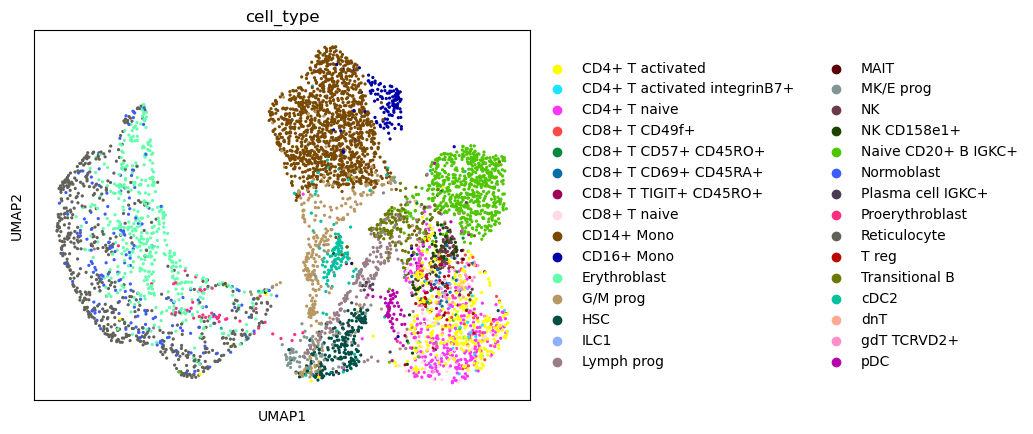

In [3]:
import scanpy as sc
sc.pp.neighbors(ad_data)
sc.tl.umap(ad_data)
sc.pl.umap(ad_data, color="cell_type")

### Data preprocessing

Before running scMaui, data preprocessing is required to get a better distribution of the modalities. The preprocessing strategies are up to users. You can see the [scanpy preprocessing tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html#preprocessing) to find an appropriate preprocessing strategy for your data. 

Firstly, we split the RNA-seq and protein expression modalities from the original data since scMaui requires each modality in a separate object. 

In [4]:
ad_gex = ad_data[:,ad_data.var["feature_types"]=="GEX"].copy()
ad_adt = ad_data[:,ad_data.var["feature_types"]=="ADT"].copy()

In this data set, the RNA-seq has ~ 100 times more features than the protein expression modality thus we mainly preprocess the RNA-seq features to choose a subset of genes which are highly variable across cells. 

In [5]:
# filter sparse features
sc.pp.filter_genes(ad_gex, min_cells=10)
# normalisation
sc.pp.normalize_total(ad_gex, exclude_highly_expressed=True)
# log1p-transformation
sc.pp.log1p(ad_gex)
# choose top 5k most highly variable genes
sc.pp.highly_variable_genes(ad_gex, n_top_genes=5000)
ad_gex = ad_gex[:, ad_gex.var["highly_variable"]].copy()
ad_gex

AnnData object with n_obs × n_vars = 5584 × 5000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'organism', 'neighbors', 'umap', 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

We save each modality object to load the data usign the scMaui interface. 

In [6]:
ad_gex.write("../data/CITE-seq/gex.h5ad")
ad_adt.write("../data/CITE-seq/adt.h5ad")

### Run scMaui

Now we run scMaui with the two saved modalities. Details about running scMaui is described in [Tutorial 02](https://github.com/BIMSBbioinfo/scmaui-experiments/blob/5347ce3673602dd8d0ff89760ebb212d8707aa38/tutorials/02.%20Run%20scMaui%20on%20single-cell%20multiomics%20dataset.ipynb). In this data set, we do not assign any batch effect factor since the subset was collected from the same donor and same sequencing site. 

In [7]:
from scmaui.data import load_data, SCDataset
import os 

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # This line is for avoiding tensorflow models to be allocated to GPUs
adatas = load_data(["../data/CITE-seq/gex.h5ad",
                   "../data/CITE-seq/adt.h5ad"],
                  names=["gex", "adt"])

dataset = SCDataset(adatas, losses=["negbinom", "negbinom"],
                    union=True)
dataset

Inputs: non-missing/samples x features
	gex: 5584/5584 x 5000
	adt: 5584/5584 x 134
Outputs:
	gex: 5584/5584 x 5000
	adt: 5584/5584 x 134
0 Adversarials: []
0 Conditionals: []

In [8]:
from scmaui.utils import init_model_params

params = init_model_params()
params.update({'losses': dataset.losses})
params['kl_weight'] = 0.3
modalities = dataset.modalities()
params['input_modality'] = modalities[0]
params['output_modality'] = modalities[1]

params.update(dataset.adversarial_config())
params.update(dataset.conditional_config())
params

OrderedDict([('nunits_encoder', 32),
             ('nlayers_encoder', 5),
             ('nunits_decoder', 20),
             ('nlayers_decoder', 1),
             ('dropout_input', 0.1),
             ('dropout_encoder', 0.0),
             ('dropout_decoder', 0.0),
             ('nunits_adversary', 128),
             ('nlayers_adversary', 2),
             ('kl_weight', 0.3),
             ('nlatent', 10),
             ('nmixcomp', 1),
             ('losses', ['negbinom', 'negbinom']),
             ('input_modality', ['gex', 'adt']),
             ('output_modality', ['gex', 'adt']),
             ('adversarial_name', []),
             ('adversarial_dim', []),
             ('adversarial_type', []),
             ('conditional_name', []),
             ('conditional_dim', []),
             ('conditional_type', [])])

In [9]:
from scmaui.ensembles import EnsembleVAE

ensemble = EnsembleVAE(params=params, ensemble_size=1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # This line disables Tensorflow debugging information
train_loss = ensemble.fit(dataset, epochs=100, 
                          learning_rate=0.001, batch_size=128)

using vae


2024-06-12 15:42:32.805465: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-12 15:42:32.805505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: yuni-desktop
2024-06-12 15:42:32.805512: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: yuni-desktop
2024-06-12 15:42:32.805629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 550.67.0
2024-06-12 15:42:32.805657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 550.67.0
2024-06-12 15:42:32.805663: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 550.67.0
2024-06-12 15:42:32.805912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

Run model 1
Epoch 1/100
38/38 - 5s - kl: 90.0513 - recon: 2335.4749 - loss: 2425.5261 - val_kl: 48.0756 - val_recon: 2676.3286 - val_loss: 2724.4043 - 5s/epoch - 126ms/step
Epoch 2/100
38/38 - 2s - kl: 89.8674 - recon: 1991.9790 - loss: 2081.8464 - val_kl: 52.7212 - val_recon: 2315.2920 - val_loss: 2368.0132 - 2s/epoch - 40ms/step
Epoch 3/100
38/38 - 2s - kl: 100.2982 - recon: 1984.3370 - loss: 2084.6353 - val_kl: 49.0626 - val_recon: 2207.4934 - val_loss: 2256.5559 - 2s/epoch - 41ms/step
Epoch 4/100
38/38 - 2s - kl: 58.4414 - recon: 1817.7356 - loss: 1876.1770 - val_kl: 38.5814 - val_recon: 2166.7822 - val_loss: 2205.3638 - 2s/epoch - 41ms/step
Epoch 5/100
38/38 - 2s - kl: 64.8280 - recon: 2079.4939 - loss: 2144.3218 - val_kl: 35.2002 - val_recon: 2131.0483 - val_loss: 2166.2485 - 2s/epoch - 41ms/step
Epoch 6/100
38/38 - 2s - kl: 45.4525 - recon: 2124.5237 - loss: 2169.9761 - val_kl: 33.3861 - val_recon: 2100.6958 - val_loss: 2134.0818 - 2s/epoch - 41ms/step
Epoch 7/100
38/38 - 2s - k

Although we ran scMaui for 100 epochs here, we highly recommend to **increase the number of epochs** for a bigger data set. (e.g., 1500 epochs were used for the full data set in the scMaui paper.)

### scMaui integration result

After training the scMaui model, we obtain the final latent values by using the _encode_ function.   

88/88 [==============================] - 1s 4ms/step


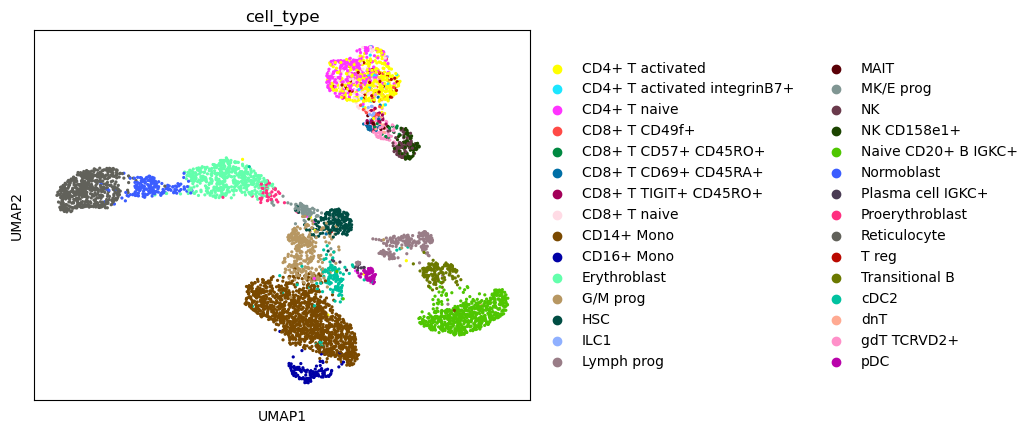

In [10]:
latent, latent_list = ensemble.encode(dataset)
ad_gex.obsm["scMaui_latent"]= latent
sc.pp.neighbors(ad_gex, use_rep="scMaui_latent")
sc.tl.umap(ad_gex)
sc.pl.umap(ad_gex, color=["cell_type"], ncols=1)

Compared to the previous UMAP created with raw counts, the UMAP calculated from scMaui latent values makes much better cell-type representations. The cell types are also better reconstructed than the UMAP calculated with pre-processed data (but without integration, shown below). 

         Falling back to preprocessing with `sc.pp.pca` and default params.


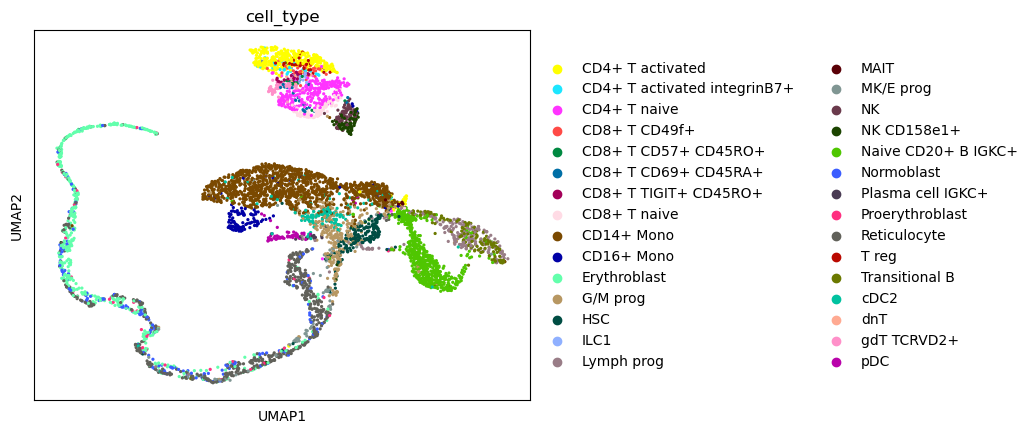

In [12]:
import anndata as ad
ad_merge = ad.concat([ad_gex, ad_adt], join="outer", axis=1)
ad_merge.obs = ad_gex.obs.copy()
sc.pp.neighbors(ad_merge)
sc.tl.umap(ad_merge)
sc.pl.umap(ad_merge, color=["cell_type"], ncols=1)